# **PROJECT-3. Анализ воронки**

ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ
В рамках проверки гипотез вам необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)


**Важно! Выполнять задание необходимо на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).**




In [1]:
#Прочитаем исходные данные и создадим их копии

import pandas as pd
purchase = pd.read_csv('purchase.csv',sep = ',')
events = pd.read_csv('7_4_Events.csv',sep = ',')
purch = purchase.copy()
event = events.copy()


In [2]:
#ПОДГОТОВКА И ОЧИСТКА ДАННЫХ

# 1.Переименуем столбцы в таблицах, которые имеют одинаковое название, но разное значение,  
# и столбцы с одинаковым значением. Добавим столбец "event_type" в таблицу с оплатами со значениями "purchase". 
# Приведем столбец с датами к типу datetime*

event = event.rename(columns= {'id':'event_id'})
purch = purch.rename(columns={'id':'purchase_id','event_datetime': "start_time"})
purch['event_type'] = 'purchase'

event['start_time'] = pd.to_datetime(event['start_time'],errors = 'coerce')
purch['start_time'] = pd.to_datetime(purch['start_time'])



# 2.В datаFrame 'event'  выделим всех кто с '2018-01-01' до '2019-01-01' и  зарегистрировался в новый 
# datаFrame events_df*

correct_time = (event['start_time'] < '2019-01-01')&(event['event_type'] == 'registration')&(event['start_time'] >= '2018-01-01')
users_2018 = event[correct_time]['user_id'].to_list()
events_df = event[event['user_id'].isin(users_2018)] #DataFrame со всеми событиями польз-лей,которые (зарег-сь в 2018 году)

# 3.В 'purch' выделим всех кто с '2018-01-01' до '2019-01-01' зарегистрировался, используем список users_2018, 
# так как там все кто зарег. в нужный нам период*
purchase_df = purch[purch['user_id'].isin(users_2018)]#DataFrame со всеми оплатами польз-лей,которые (зарег-сь в 2018 году)

# 4.Объединим 2 таблицы в единый datаFrame*
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')#DataFrame со всеми оплатами и событиями польз-лей (зарег-сь в 2018 году)



### **1. Насколько обучение сокращает время прохождения этапов игры.**

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.


Определим сколько в среднем раз пользователи завершают обучение.
Для дальнейшего сравнения групп пользователей прошедших и не прошедших обучение, будем сравнивать время между следующими этапами:
- Регистрация - Выбор уровня сложности
- Регистрация - Выбор пакетов вопросов
- Регистрация - Покупка платных пакетов вопросов
- Выбор уровня сложности - Выбор пакетов вопросов
- Выбор пакетов вопросов - Покупка платных пакетов вопросов


Расчитаем время прохождения различных этапов для пользователей которые ЗАВЕРШИЛИ ОБУЧЕНИЕ

In [3]:
#ЗАВЕРШИЛИ ОБУЧЕНИЕ
#Определим сколько в среднем раз пользователи завершают обучение
#_______________________________________________________________

users_tutorial_finish_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish']
print(users_tutorial_finish_df['user_id'].value_counts().mean())
#Полученный ответ 1.45 означает, что некоторые пользователи проходити обучение не один раз.
#Это может говорить о том, что обучение не достаточно понятное и нуждается в доработке.
#Используем пользователей которые завершили обучение.

#список пользователей завершивших обучение
#_______________________________________________________________
users_tutorial_finish = users_tutorial_finish_df['user_id'].drop_duplicates().to_list()


#Созданим ДатаФреймы с событиями (регистрация, выбор уровня, выбор пакета вопросов, покупка)
#________________________________________________________________

#зарегистрировались и прошли обучение
df_regist_tf = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish))&(total_events_df['event_type']=='registration')]
print(df_regist_tf['user_id'].value_counts().mean())
df_regist_tf = df_regist_tf[['user_id', 'start_time']].rename(columns={'start_time':'registration_time'})

#выбрали уровень и прошли обучение
df_level_tf = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish))&(total_events_df['event_type']=='level_choice')]
print(df_level_tf['user_id'].value_counts().mean())
df_level_tf = df_level_tf[['user_id', 'start_time']].rename(columns={'start_time':'level_choice_time'})

#Выбор пакетов вопросов и прошли обучение
df_pack_choice_tf = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish))&(total_events_df['event_type']=='pack_choice')]
print(df_pack_choice_tf['user_id'].value_counts().mean())
df_pack_choice_tf = df_pack_choice_tf[['user_id', 'start_time']].rename(columns={'start_time':'pack_choice_time'})

#Покупка платных пакетов вопросов и прошли обучение
df_purch_tf = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish))&(total_events_df['event_type']=='purchase')]
print(df_purch_tf['user_id'].value_counts().mean()) 
df_purch_tf = df_purch_tf[['user_id', 'start_time']].rename(columns={'start_time':'purchase_time'})

1.4540487804878048
1.0
1.0
1.0
1.0


In [4]:
#ЗАВЕРШИЛИ ОБУЧЕНИЕ
#Будем объединять полученные DataFrame с нужными событиями для получения разности во времени между ними.
#_______________________________________________________________________________________________________



#Регистрация - Выбор уровня сложности
df_reg_level_tf = df_regist_tf.merge(df_level_tf,on='user_id',how='inner')
df_reg_level_tf['reg_level_time'] = df_reg_level_tf['level_choice_time'] - df_reg_level_tf['registration_time']
reg_level_time_mean = df_reg_level_tf['reg_level_time'].mean()

#- Регистрация - Выбор пакетов вопросов
df_reg_pack_choice_ft = df_regist_tf.merge(df_pack_choice_tf, on='user_id',how='inner')
df_reg_pack_choice_ft['reg_pack_choice_time'] = df_reg_pack_choice_ft ['pack_choice_time']- df_reg_pack_choice_ft['registration_time']
reg_pack_choice_time_mean = df_reg_pack_choice_ft['reg_pack_choice_time'].mean()


#- Регистрация - Покупка платных пакетов вопросов
df_reg_purch_ft = df_regist_tf.merge(df_purch_tf, on='user_id',how='inner')
df_reg_purch_ft['reg_purch_time'] = df_reg_purch_ft['purchase_time'] - df_reg_purch_ft['registration_time']
reg_purch_time_mean = df_reg_purch_ft['reg_purch_time'].mean()

#- Выбор уровня сложности - Выбор пакетов вопросов
df_level_pack_tf = df_level_tf.merge(df_pack_choice_tf, on='user_id',how='inner')
df_level_pack_tf['level_pack_time'] = df_level_pack_tf['pack_choice_time'] - df_level_pack_tf['level_choice_time']
level_pack_time_mean = df_level_pack_tf['level_pack_time'].mean()


#- Выбор пакетов вопросов - Покупка платных пакетов вопросов
df_pack_purch_tf = df_pack_choice_tf.merge(df_purch_tf, on='user_id',how='inner')
df_pack_purch_tf['pack_purch_time'] = df_pack_purch_tf['purchase_time'] - df_pack_purch_tf['pack_choice_time']
pack_purch_time_mean = df_pack_purch_tf['pack_purch_time'].mean()





Расчитаем время прохождения различных этапов для пользователей которые НЕ НАЧАЛИ ОБУЧЕНИЕ.


In [5]:
#НЕ НАЧАЛИ ОБУЧЕНИЕ

#Выделим пользователей, которые не начинали обучение
#__________________________________________________________________

all_users = total_events_df['user_id'].unique()
set_all_users = set(all_users) #сет в котором все пользователи

users_with_st_tut = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_st_tut = set(users_with_st_tut)#сет в котором все пользователи начавшие обучение


set_users_not_st_tut = set_all_users.difference(set_users_with_st_tut)
users_not_st_tut = list(set_users_not_st_tut)#сет в котором все пользователи  не начавшие обучение
print(len(users_not_st_tut))


8068


In [6]:
#создадим Датафреймы с пользователями которые не проходили обучение и имеют события:
#регистрации, выбор уровня, выбор пакетов, покупка платных пакетов.
#____________________________________________________________________

#зарегистрировались и НЕ прошли обучение
df_regist_not_tut = total_events_df[(total_events_df['user_id'].isin(users_not_st_tut))&(total_events_df['event_type']=='registration')]
print(df_regist_not_tut['user_id'].value_counts().mean())
df_regist_not_tut = df_regist_not_tut[['user_id', 'start_time']].rename(columns={'start_time':'registration_time'})


#выбрали уровень и НЕ прошли обучение
df_level_not_tut = total_events_df[(total_events_df['user_id'].isin(users_not_st_tut))&(total_events_df['event_type']=='level_choice')]
print(df_level_not_tut['user_id'].value_counts().mean())
df_level_not_tut = df_level_not_tut[['user_id', 'start_time']].rename(columns={'start_time':'level_choice_time'})


#Выбор пакетов вопросов и НЕ прошли обучение
df_pack_choice_not_tut = total_events_df[(total_events_df['user_id'].isin(users_not_st_tut))&(total_events_df['event_type']=='pack_choice')]
print(df_pack_choice_not_tut['user_id'].value_counts().mean())
df_pack_choice_not_tut = df_pack_choice_not_tut[['user_id', 'start_time']].rename(columns={'start_time':'pack_choice_time'})


#Покупка платных пакетов вопросов и НЕ прошли обучение
df_purch_not_tut = total_events_df[(total_events_df['user_id'].isin(users_not_st_tut))&(total_events_df['event_type']=='purchase')]
print(df_purch_not_tut['user_id'].value_counts().mean()) 
df_purch_not_tut = df_purch_not_tut[['user_id', 'start_time']].rename(columns={'start_time':'purchase_time'})



1.0
1.0
1.0
1.0


In [7]:

# НЕ ПРОХОДИЛИ ОБУЧЕНИЕ
#Будем объединять полученные DataFrame с нужными событиями для получения разности во времени между ними.
#____________________________________________________________



#Регистрация - Выбор уровня сложности
df_reg_level_not_tut = df_regist_not_tut.merge(df_level_not_tut,on='user_id',how='inner')
df_reg_level_not_tut['reg_level_time'] = (df_reg_level_not_tut['level_choice_time'] - df_reg_level_not_tut['registration_time'])
reg_level_time_not_tut_mean = df_reg_level_not_tut['reg_level_time'].mean()


#- Регистрация - Выбор пакетов вопросов
df_reg_pack_choice_not_tut = df_regist_not_tut.merge(df_pack_choice_not_tut, on='user_id',how='inner')
df_reg_pack_choice_not_tut['reg_pack_choice_time'] = df_reg_pack_choice_not_tut['pack_choice_time']- df_reg_pack_choice_not_tut['registration_time']
reg_pack_choice_time_not_tut_mean = df_reg_pack_choice_not_tut['reg_pack_choice_time'].mean()


#- Регистрация - Покупка платных пакетов вопросов
df_reg_purch_not_tut = df_regist_not_tut.merge(df_purch_not_tut, on='user_id',how='inner')
df_reg_purch_not_tut['reg_purch_time'] = df_reg_purch_not_tut['purchase_time'] - df_reg_purch_not_tut['registration_time']
reg_purch_time_not_tut_mean = df_reg_purch_not_tut['reg_purch_time'].mean()

#- Выбор уровня сложности - Выбор пакетов вопросов
df_level_pack_not_tut = df_level_not_tut.merge(df_pack_choice_not_tut, on='user_id',how='inner')
df_level_pack_not_tut['level_pack_time'] = df_level_pack_not_tut['pack_choice_time'] - df_level_pack_not_tut['level_choice_time']
level_pack_time_not_tut_mean = df_level_pack_not_tut['level_pack_time'].mean()

#- Выбор пакетов вопросов - Покупка платных пакетов вопросов
df_pack_purch_not_tut = df_pack_choice_not_tut.merge(df_purch_not_tut, on='user_id',how='inner')
df_pack_purch_not_tut['pack_purch_time'] = df_pack_purch_not_tut['purchase_time'] - df_pack_purch_not_tut['pack_choice_time']
pack_purch_time_not_tut_mean = df_pack_purch_not_tut['pack_purch_time'].mean()



In [8]:
#Сравним время между различными этапами для пользователей ПРОШЕДШИХ и НЕ ПРОШЕДШИХ обучение

mean_tut_fin = [reg_level_time_mean,reg_pack_choice_time_mean,reg_purch_time_mean,level_pack_time_mean,
pack_purch_time_mean]

mean_not_tut = [reg_level_time_not_tut_mean,reg_pack_choice_time_not_tut_mean,
reg_purch_time_not_tut_mean,level_pack_time_not_tut_mean,pack_purch_time_not_tut_mean]


mean_tut_fin_2 = []
for i in mean_tut_fin:
        i = i.total_seconds()/(60*60)
        mean_tut_fin_2.append(i)
        
mean_not_tut2=[]  
for i in mean_not_tut:
        i = i.total_seconds()/(60*60)
        mean_not_tut2.append(i)    



delta_time_tutfin_nottut = pd.DataFrame({'Прошли обучение,ч':mean_tut_fin_2,
                                         'Не прошли обучение,ч':mean_not_tut2},
                                        index= ['Регистрация - Выбор уровня сложности',
                                                'Регистрация - Выбор пакетов вопросов',
                                                'Регистрация - Покупка платных пакетов вопросов',
                                                'Выбор уровня сложности - Выбор пакетов вопросов',
                                                'Выбор пакетов вопросов - Покупка платных пакетов вопросов'])
                                        
                                        


print('Данные ниже касаются пользователей зарегистрированных в 2018 году')
display(delta_time_tutfin_nottut)



Данные ниже касаются пользователей зарегистрированных в 2018 году


,"Прошли обучение,ч","Не прошли обучение,ч"
Регистрация - Выбор уровня сложности,7.093571,5.259201
Регистрация - Выбор пакетов вопросов,7.176572,5.121160
Регистрация - Покупка платных пакетов вопросов,96.500902,105.100530
Выбор уровня сложности - Выбор пакетов вопросов,0.088374,0.089951
Выбор пакетов вопросов - Покупка платных пакетов вопросов,89.299900,100.825997


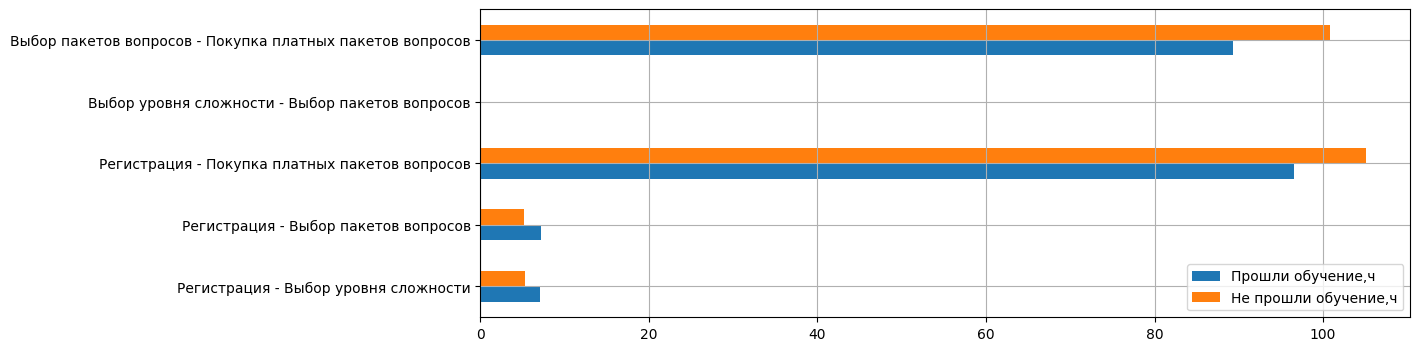

In [9]:
delta_time_tutfin_nottut.plot(
    kind='barh',
    grid=True,
    figsize=(12,4)
);

### **ВЫВОД 1. Насколько обучение сокращает время прохождения этапов игры.**
На графике видно: что у пользователей прошедших обучение, среднее время между "Регистрация - Выбор уровня сложности"и "Регистрация - Выбор пакетов вопросов" больше, чем у пользователей, которые не проходили обучение. Это связано с тем, что пользователи, которые не проходили обучение, миновали процесс обучения, который идет сразу после регистрации и сразу приступили к дальнейшим этапам.

Среднее время между "Выбор уровня сложности - Выбор пакетов вопросов" у пользователей которые проходили и не проходили обучение сравнительно не большое около 0,09ч (около 5 минут)

Также видно, что у пользователей прошедших обучение, среднее время между "Регистрация - Покупка платных пакетов вопросов" и "Выбор пакетов вопросов - Покупка платных пакетов вопросов" меньше, чем у пользователей, которые не проходили обучение. 

Таким образом можно сказать, что прохождение обучения положительно сказывается на времени прохождения полного цикла этапов ведущих к покупке пакетов вопросов.



### **2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.**

Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

In [10]:
#выделить пользователей по количеству обучений 

count_of_event = total_events_df[["user_id", "event_type"]]
count_of_event.insert(2, 'count_ivent', 1)
count_of_event = count_of_event.pivot_table(values= 'count_ivent', index="user_id", columns="event_type", aggfunc='sum',fill_value=0)


count_of_tut_start = count_of_event.groupby("tutorial_start")["tutorial_start"].count()
count_of_tut_fin = count_of_event.groupby("tutorial_finish")["tutorial_finish"].count()
count_of_purch_tut_start = count_of_event.pivot_table(values= 'purchase', index="tutorial_start", aggfunc='sum')
count_of_purch_tut_fin = count_of_event.pivot_table(values= 'purchase', index="tutorial_finish", aggfunc='sum')
count_of_purch_tut = pd.concat([count_of_tut_start,count_of_purch_tut_start,count_of_tut_fin, count_of_purch_tut_fin], axis=1)
count_of_purch_tut.columns = ['number of users have "tutorial_start" N times', 'number of users have "purchase" and "tutorial_start" N times','number of users have "tutorial_finish" N times', 'number of users have "purchase" and "tutorial_finish" N times']
count_of_purch_tut['percentage of purchases for"tutorial_start"'] = (count_of_purch_tut['number of users have "purchase" and "tutorial_start" N times']/count_of_purch_tut['number of users have "tutorial_start" N times'])*100
count_of_purch_tut['percentage of purchases for"tutorial_finish"'] = (count_of_purch_tut['number of users have "purchase" and "tutorial_finish" N times']/count_of_purch_tut['number of users have "tutorial_finish" N times'])*100


display(count_of_purch_tut)


,"number of users have ""tutorial_start"" N times","number of users have ""purchase"" and ""tutorial_start"" N times","number of users have ""tutorial_finish"" N times","number of users have ""purchase"" and ""tutorial_finish"" N times","percentage of purchases for""tutorial_start""","percentage of purchases for""tutorial_finish"""
0,8068,22,9676,153,0.272682,1.581232
1,9103,1207,8015,1143,13.259365,14.260761
2,1589,218,1321,182,13.719320,13.777441
3,427,51,345,44,11.943794,12.753623
4,221,30,178,19,13.574661,10.674157
5,109,16,117,19,14.678899,16.239316
6,116,14,101,15,12.068966,14.851485
7,94,12,97,15,12.765957,15.463918
8,86,13,54,6,15.116279,11.111111
9,113,17,22,4,15.044248,18.181818


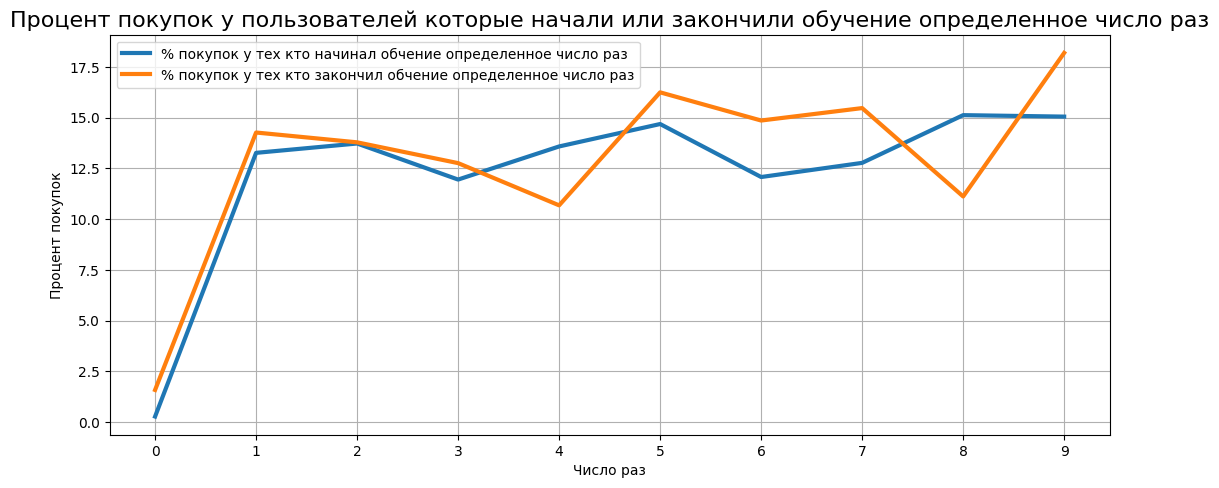

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(count_of_purch_tut['percentage of purchases for"tutorial_start"'], label='% покупок у тех кто начинал обчение определенное число раз', lw=3)
axes.plot(count_of_purch_tut['percentage of purchases for"tutorial_finish"'], label='% покупок у тех кто закончил обчение определенное число раз', lw=3)

#установка параметров отображения
axes.set_title('Процент покупок у пользователей которые начали или закончили обучение определенное число раз', fontsize=16)
axes.set_xlabel('Число раз')
axes.set_ylabel('Процент покупок')
axes.set_xticks(range(0, 10))
axes.grid()
axes.legend();

In [12]:
#дополнительно оценим количество укальных пользователей прошедших и не прошедших обучение 
# и сколько из них совершили покупки


total_events_df_ft = total_events_df[total_events_df['user_id'].isin(users_tutorial_finish)]
users_tutorial_finish_count = total_events_df_ft['user_id'].nunique()
total_events_df_purch_ft = total_events_df_ft[total_events_df_ft['event_type']=='purchase']
users_tutorial_finish_purch_count = total_events_df_purch_ft['user_id'].nunique()


total_events_df_not_tut = total_events_df[total_events_df['user_id'].isin(users_not_st_tut)]
users_tutorial_not_tut = total_events_df_not_tut['user_id'].nunique()
total_events_df_purch_not_tut = total_events_df_not_tut[total_events_df_not_tut['event_type']=='purchase']
users_tutorial_purch_not_tut =total_events_df_purch_not_tut['user_id'].nunique()

count_tut_df = pd.DataFrame({'Прошли обучение':[users_tutorial_finish_count, users_tutorial_finish_purch_count],
                             'Не прошли обучение':[users_tutorial_not_tut, users_tutorial_purch_not_tut]},
                            index=['Кол-во таких польз-лей','Из них, совершили покупку'])

print('Данные ниже касаются пользователей зарегистрированных в 2018 году')
display(count_tut_df)

Данные ниже касаются пользователей зарегистрированных в 2018 году


,Прошли обучение,Не прошли обучение
Кол-во таких польз-лей,10250,8068
"Из них, совершили покупку",1447,22


Text(0.5, 1.0, 'Не прошли обучение')

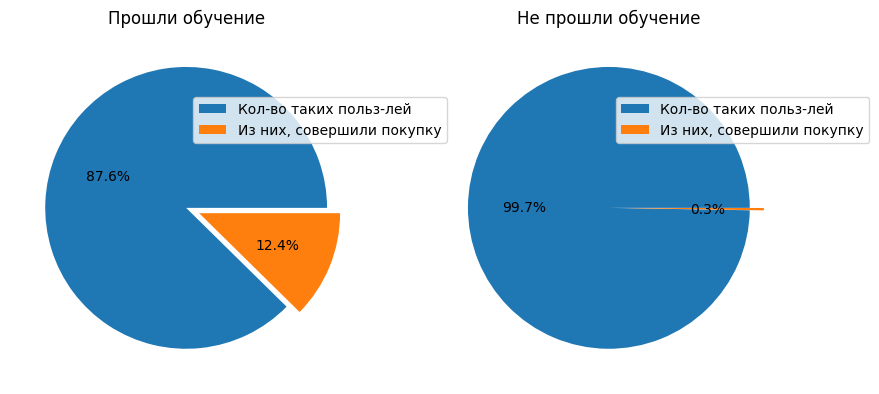

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].pie(
    count_tut_df['Прошли обучение'],
    autopct='%.1f%%',
    explode = [0, 0.1],
    labeldistance = 0.1
)
axes[0].legend(count_tut_df.index,
          loc="center left",
          bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
axes[0].set_title('Прошли обучение')

axes[1].pie(
    count_tut_df['Не прошли обучение'],
    autopct='%.1f%%',
    explode = [0, 0.1]
)
axes[1].legend(count_tut_df.index,
          loc="center left",
          bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
axes[1].set_title('Не прошли обучение')

### **ВЫВОД 2.**
Из круговых диаграмм выше видно, что пользователи, которые прошли обучение совершают покупку в 12.4% случаев. Те пользователи которые не начинали обучение, совершают покупку только в 0.3% случаев. Т.е можно с уверенностью сказать, что прохождение обучения положительно влияет на дальнейшую покупку.

Если рассматривать пользователей, которые начали или закончили обучение, у них число прохождений (начало обучения/окончание обучения) варьируется от 0 до 9. Если пользователь не начинал и не заканчивал обучение процент покупки крайне низкий 0.27%(не начали обучение) и 1.58%(не закончили обучение). Если пользовать начал обучение 1 раз процент покупки повышается до 13.26%, если пользовать закончил обучение 1 раз процент покупки повышается до 14.26%. С ростом количество стартов обучения или завершения обучения, процент покупок не падает ниже 10%. Таким образом можно сказать, что рост количества прохождений обучения не сказывается отрицательно на % покупок. Однако стоит обратить внимание, что большое количество пользователей вынуждены проходить обучение повторно.

### **3. Определить, насколько прозрачен процесс взаимодействия с игрой.** 
Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [14]:

total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
user_path_df = (total_events_df.groupby(["user_id"])["event_type"].apply(list).reset_index())
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))


users_lev_ch = len(list(user_path_df[user_path_df["event_path"].str.contains('level_choice')]["user_id"].unique()))

import re 

pattern = r'.+level_choice.+tutorial_start.+'
user_path_df['pattern'] = user_path_df["event_path"].apply(lambda x:re.findall(pattern, x))
user_path_df['pattern'] = user_path_df['pattern'].apply(lambda x:1 if x!=[] else 2)
count_users_lev_ch_ts = user_path_df[user_path_df['pattern']==1]['pattern'].count()


all_us_lev_ch = pd.DataFrame({'Выбрали уровень':[users_lev_ch - count_users_lev_ch_ts, count_users_lev_ch_ts]},
                            index=['Кол-во польз-лей НЕ НАЧАЛИ обучение после выбора уровня',
                                   'Кол-во польз-лей НАЧАЛИ обучение после выбора уровня'])

print('Данные ниже касаются пользователей зарегистрированных в 2018 году')
display(all_us_lev_ch)

Данные ниже касаются пользователей зарегистрированных в 2018 году


,Выбрали уровень
Кол-во польз-лей НЕ НАЧАЛИ обучение после выбора уровня,7090
Кол-во польз-лей НАЧАЛИ обучение после выбора уровня,1252


Text(0.5, 1.0, 'Пользователи которые выбрали уровень')

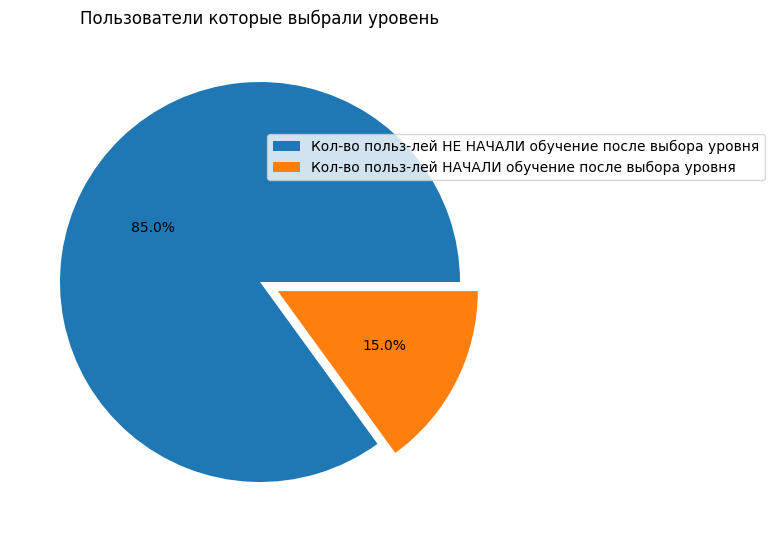

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])

axes.pie(
    all_us_lev_ch['Выбрали уровень'],
    autopct='%.1f%%',
    explode = [0, 0.1],
    labeldistance = 0.1
)
axes.legend(all_us_lev_ch.index,
          loc="center left",
          bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
axes.set_title('Пользователи которые выбрали уровень')

### **ВЫВОД 3.** 
Из всех пользователей которые выбрали уровень, 15% начинают обучение после выбора уровня сложности. 1252 пользователя начали обучение после выбора уровня сложности, это довольно много. Т.е необходима доработка процесса, для большей прозрачности. Учитывая данные из пункта 2, видим что большое количество пользователей возвращаются к обучению повторно, значит процесс не совсем понятен.